In [1]:
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart
import matplotlib.pyplot as plt
import asyncio
import datetime
import random
import websockets
import nest_asyncio
import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import run_websocket_server, run_http_server
import tensorflow as tf
sys.path.insert(0, os.path.abspath('..'))
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain

nest_asyncio.apply()

logger = logging.getLogger('TfPoseEstimatorRun')
logger.handlers.clear()
logger.setLevel(logging.ERROR)
ch = logging.StreamHandler()
ch.setLevel(logging.ERROR)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Using tf version = 1.15.0


In [2]:
# params 432, 368
w, h = 432, 368
image_path = './data/images/muscle_black1.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image = common.read_imgfile(image_path, w, h)

In [3]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)

[2019-12-30 17:53:53,703] [TfPoseEstimator] [INFO] loading graph from /home/ax/Programs/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=432x368)
2019-12-30 17:53:53,703 INFO loading graph from /home/ax/Programs/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=432x368)


2019-12-30 17:53:53,708 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:311: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



2019-12-30 17:53:53,709 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:312: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



2019-12-30 17:53:53,958 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:330: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2019-12-30 17:53:54,292 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:332: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2019-12-30 17:53:54,367 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:339: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2019-12-30 17:53:54,368 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:340: The name tf.image.resize_area is deprecated. Please use tf.compat.v1.image.resize_area instead.



2019-12-30 17:53:54,375 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/tensblur/smoother.py:96: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-12-30 17:53:54,388 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:352: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-12-30 17:53:54,390 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:357: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2019-12-30 17:53:54,391 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:358: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2019-12-30 17:53:54,392 WARNING From /home/ax/Programs/tf-pose-estimation/tf_pose/estimator.py:360: The name tf.report_uninitialized_variables is deprecated. Please use tf.compat.v1.report_uninitialized_variables instead.



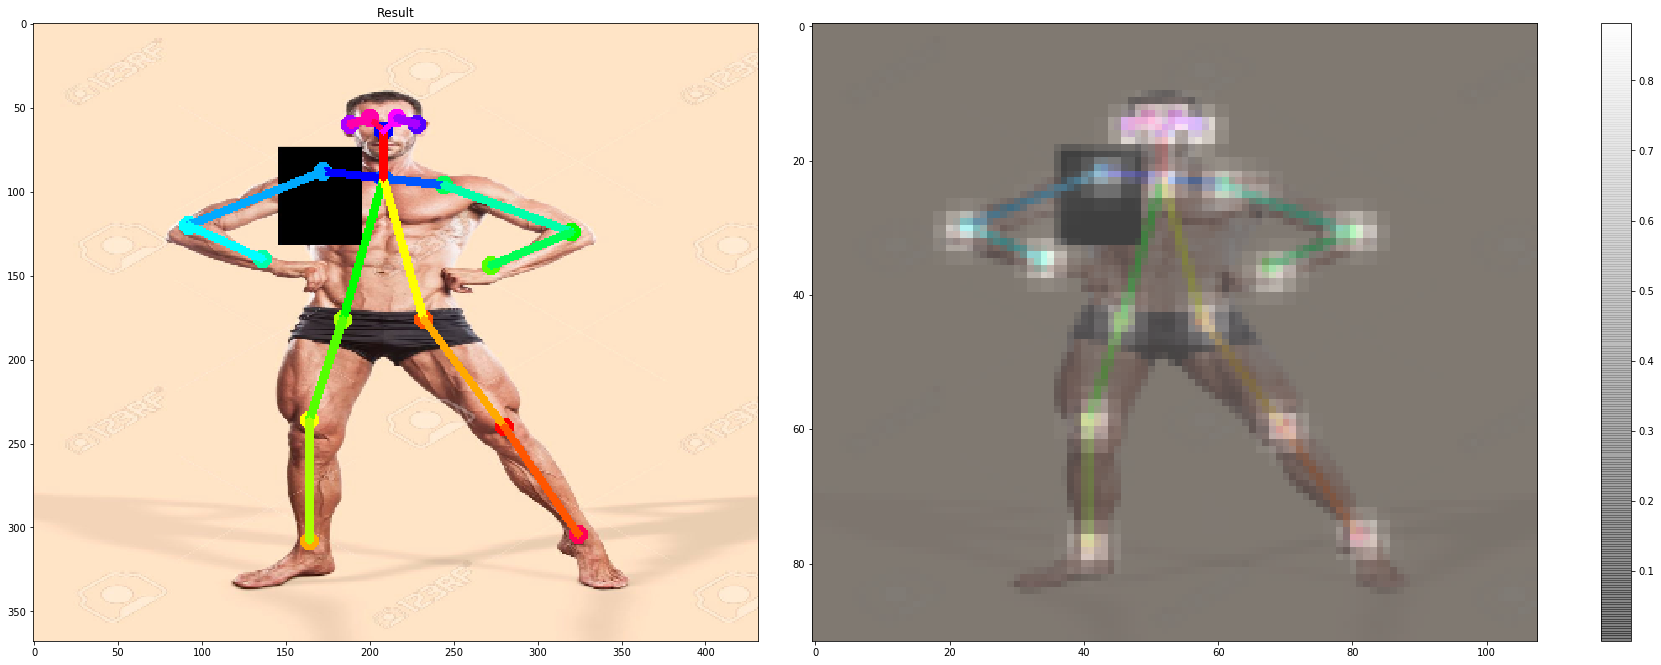

In [4]:
# estimate human poses from a single image !
humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
image_result = TfPoseEstimator.draw_humans(image, humans, imgcopy=True)

fig = plt.figure(figsize=(50, 25))
a = fig.add_subplot(2, 1, 1)
a.set_title('Result')
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))

bgimg = cv2.cvtColor(image_result.astype(np.uint8), cv2.COLOR_BGR2RGB)
bgimg = cv2.resize(bgimg, (e.heatMat.shape[1], e.heatMat.shape[0]), interpolation=cv2.INTER_AREA)

# show network output
a = fig.add_subplot(2, 2, 2)
plt.imshow(bgimg, alpha=0.5)
tmp = np.amax(e.heatMat[:, :, :-1], axis=2)
plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
_ = plt.colorbar()

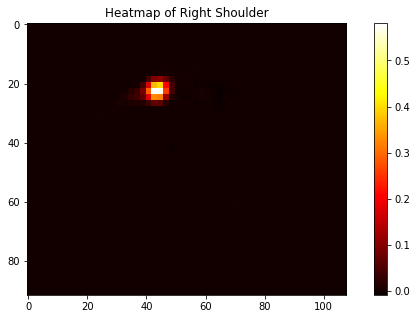

In [5]:
# show network output
fig = plt.figure(figsize=(10, 5))

# plt.imshow(bgimg, alpha=0.5)
heatmap = e.heatMat[:, :, CocoPart.RShoulder.value]
plt.imshow(heatmap, cmap=plt.cm.hot, alpha=1.0)
plt.title('Heatmap of Right Shoulder')
_ = plt.colorbar()

In [6]:
x, y = np.unravel_index(heatmap.argmax(), tmp.shape)
print(f'Max value {heatmap[x, y]} at ({x}, {y})')
print(np.sum(heatmap))
print(e.heatMat.shape, str(type(e.heatMat)))
print(e.pafMat.shape, str(type(e.pafMat)))

print(e.tensor_output.shape, str(type(e.tensor_output)))
print(e.tensor_image.shape, str(type(e.tensor_image)))

Max value 0.5812479853630066 at (22, 42)
19.660835
(92, 108, 19) <class 'numpy.ndarray'>
(92, 108, 38) <class 'numpy.ndarray'>
(?, ?, ?, 57) <class 'tensorflow.python.framework.ops.Tensor'>
(?, ?, ?, 3) <class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
# get the current session
sess = e.persistent_sess
#tf.reset_default_graph()
#sess = tf.Session()
LOGDIR = './logs/openPose'

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=e.graph) as de:
    train_writer = tf.summary.FileWriter(LOGDIR)
    train_writer.add_graph(e.graph)
    
    input_tensor = e.tensor_image
    #output_tensor = e.tensor_heatMat[:, x, y, CocoPart.RShoulder.value]
    output_tensor = e.tensor_heatMat[:, :, :, CocoPart.RShoulder.value]
    xs = tf.expand_dims(image, 0).eval(session=sess)
    xs = xs.astype('float64')
    # print(output_tensor.shape, str(type(output_tensor)))
    # print(input_tensor.shape, str(type(input_tensor)))
    # print(xs.shape, str(type(xs)))
    # Y_shape=[None] + list(xs.shape[1:])
    Y_shape=[None] + [1, 46, 54] # size of heatmaps
    # print(Y_shape)
    baseline = np.zeros(list(xs.shape)[1:]) # baseline to compare against

    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        #'Integrated Gradients': de.explain('intgrad',  T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        #'Epsilon-LRP':          de.explain('elrp', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        #'DeepLIFT (Rescale)':   de.explain('deeplift', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        # takes 4 hours and does not really work 
        #'Occlusion [15x15]':    de.explain('occlusion', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, window_shape=(15,15,3), step=4),
        # not feasable for that size of input
        #'Shapley Sampling':     de.explain('shapley_sampling', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        'Saliency maps':        de.explain('saliency', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        'Gradient * Input':     de.explain('grad*input', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
    }

2019-12-30 17:54:05,123 INFO DeepExplain: running "shapley_sampling" explanation method (7)
2019-12-30 17:54:05,126 INFO Model with multiple inputs: False
  0%|          | 69/2384640 [01:39<992:27:06,  1.50s/it] 

In [ ]:
# MANUALLY compute saliency map
sess = e.persistent_sess

with DeepExplain(session=sess, graph=e.graph) as de:
    input_tensor = e.tensor_image
    output_tensor = e.tensor_heatMat[:, :, :, CocoPart.RShoulder.value]
    xs = tf.expand_dims(image, 0).eval(session=sess)
    xs = xs.astype('float64')
    attr_methode = [tf.abs(g) for g in tf.gradients(ys=output_tensor, xs=input_tensor)]
    
    saliency = e.persistent_sess.run(attr_methode, feed_dict = {input_tensor: xs})

In [ ]:
img_index = 0
print(f'shape = {saliency[0].shape}')
#attribution = saliency[0][img_index] # 
attribution = attributions['Saliency maps'][0]


SCALE = 10000
fig = plt.figure(figsize=(25, 15))
_ = plt.imshow(attribution * SCALE, cmap=plt.cm.hot)
print(f'min = {np.min(attribution)}')
print(f'max = {np.max(attribution)}')
print(f'mean = {np.mean(attribution)}')
print(np.allclose(saliency[0][img_index], attributions['Saliency maps'][0]))

In [ ]:
# Plot attributions
from utils import plot, plt
%matplotlib inline

n_cols = int(len(attributions)) + 1
n_rows = len(xs) 
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols*fig_scale, 3*n_rows*fig_scale))

for i, xi in enumerate(xs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, a in enumerate(attributions):
        axj = axes.flatten()[i*n_cols + j + 1]
        plot(attributions[a][i], xi = xi, axis=axj, dilation=.5, percentile=99, alpha=.2).set_title(a)